# Start here, basic imports

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from train import *
import shlex
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

In [3]:
def get_entropy_curve(all_timesteps_logits):
    # all_timesteps_logits : b x num_timesteps x num_logits 
    # returns: shannon_entropies : bs x num_timesteps
    probs = torch.nn.functional.softmax(all_timesteps_logits, dim=-1)
    shannon_entropies = (-probs * torch.log2(probs)).sum(axis=-1)
    return shannon_entropies

def get_probs(all_timesteps_logits):
    # all_timesteps_logits : b x num_timesteps x num_logits 
    # returns: probs : bs x num_timesteps x num_logits
    probs = torch.nn.functional.softmax(all_timesteps_logits, dim=-1)
    return probs

- Command to run the main training file

python train.py -cfg dalernn-t-12-gate-ln-relu -nl 3 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 0 --data /home/vveeraba/src/pathfinder_full/curv_contour_length_14 -wd 0 --in-res 160 --expname pf14_channels32_fsize7 --seed 10

# Error analysis of original model

In [ ]:
cmd = 'train.py -cfg dalernn-t-12-gate-ln-relu -nl 3 --doEntropyThresholding 0 --returnValidOutput 1 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 0 -wd 0 --in-res 160 --expname pf14_channels32_fsize7 --seed 10'
args = parser.parse_args(shlex.split(cmd))
args.cfg = load_cfg(args)
args.cfg['nlayers'] = args.nlayers
args.cfg['in_res'] = args.in_res
args.data = '/home/vveeraba/src/pathfinder_full/curv_contour_length_14'

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

# Load val data
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(args.in_res),
            transforms.ToTensor(),
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

In [ ]:
# Load existing checkpoint
print("=> loading checkpoint '{}'".format(args.resume))
# Map model to be loaded to specified single gpu.
loc = 'cuda:0'
checkpoint_file = 'ckpt_iclr/curv_contour_length_14/dalernn_gate_ln_relu/pf14_channels32_fsize7_grmfwu_seed_10/pathfinder_checkpoint_best_dalernn_gate_ln_relu.pth'  # Without entropy thresholding
checkpoint = torch.load(checkpoint_file, map_location=loc)
best_acc1 = checkpoint['val_acc1']
# create model
num_classes = 2
args.cfg = create_config(args.cfg)
model = BaseModel(args.cfg, args)
model_name = args.cfg.name  # + str(args.cfg.nlayers)
args.model_name = model_name
model.cuda()
model.load_state_dict(checkpoint['model'])

criterion = nn.CrossEntropyLoss().cuda(args.gpu)
optimizer = torch.optim.Adam(model.parameters(), args.lr,
                             # momentum=args.momentum,
                             # weight_decay=args.weight_decay
                             )
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
val_acc1, (outputs, full_outputs, targets) = validate(val_loader, model, criterion, optimizer=None, epoch=None, args=args)

In [ ]:
full_outputs = torch.transpose(full_outputs, 1, 0)

In [ ]:
(outputs.argmax(dim=-1) != targets).sum()

In [ ]:
(((outputs.argmax(dim=-1) != targets)) * (targets==0)).sum(), (((outputs.argmax(dim=-1) != targets)) * (targets==1)).sum()

In [ ]:
(((outputs.argmax(dim=-1) == targets)) * (targets==0)).sum(), (((outputs.argmax(dim=-1) == targets)) * (targets==1)).sum()

In [ ]:
entropies = get_entropy_curve(full_outputs)
probs = get_probs(full_outputs)

In [ ]:
incorrect_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==0))[0]
incorrect_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==1))[0]
correct_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0))[0]
correct_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1))[0]

In [ ]:
incorrect_gt_true_entropies = entropies[incorrect_gt_true_idxs]
incorrect_gt_false_entropies = entropies[incorrect_gt_false_idxs]
correct_gt_true_entropies = entropies[correct_gt_true_idxs]
correct_gt_false_entropies = entropies[correct_gt_false_idxs]

incorrect_gt_true_probs = probs[incorrect_gt_true_idxs][:, :, 1]
incorrect_gt_false_probs = probs[incorrect_gt_false_idxs][:, :, 0]
correct_gt_true_probs = probs[correct_gt_true_idxs][:, :, 1]
correct_gt_false_probs = probs[correct_gt_false_idxs][:, :, 0]

In [ ]:
plt.figure(figsize=(6,1))
plt.title('Entropy, Prob curve for incorrect, gt true {}'.format(incorrect_gt_true_entropies.shape[0]))
means = incorrect_gt_true_entropies.mean(axis=0).cpu().numpy()
stds = incorrect_gt_true_entropies.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)
means = incorrect_gt_true_probs.mean(axis=0).cpu().numpy()
stds = incorrect_gt_true_probs.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)

plt.figure(figsize=(6,1))
plt.title('Entropy, Prob curve for incorrect, gt false {}'.format(incorrect_gt_false_entropies.shape[0]))
means = incorrect_gt_false_entropies.mean(axis=0).cpu().numpy()
stds = incorrect_gt_false_entropies.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)
means = incorrect_gt_false_probs.mean(axis=0).cpu().numpy()
stds = incorrect_gt_false_probs.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)

plt.figure(figsize=(6,1))
plt.title('Entropy, Prob curve for correct, gt true {}'.format(correct_gt_true_entropies.shape[0]))
means = correct_gt_true_entropies.mean(axis=0).cpu().numpy()
stds = correct_gt_true_entropies.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)
means = correct_gt_true_probs.mean(axis=0).cpu().numpy()
stds = correct_gt_true_probs.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)

plt.figure(figsize=(6,1))
plt.title('Entropy, Prob curve for correct, gt false {}'.format(correct_gt_false_entropies.shape[0]))
means = correct_gt_false_entropies.mean(axis=0).cpu().numpy()
stds = correct_gt_false_entropies.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)
means = correct_gt_false_probs.mean(axis=0).cpu().numpy()
stds = correct_gt_false_probs.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)


# Entropy cutoff experiments

- When picking timestep with minimum entropy (just during validation, no change in training), performance drops from 91% to 81%.
- For random samples, analyze the entropy curve with timesteps. 

In [ ]:
cmd = 'train.py -cfg dalernn-t-12-gate-ln-relu -nl 3 --doEntropyThresholding 1 --returnValidOutput 1 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 0 -wd 0 --in-res 160 --expname pf14_channels32_fsize7 --seed 10'
args = parser.parse_args(shlex.split(cmd))
args.cfg = load_cfg(args)
args.cfg['nlayers'] = args.nlayers
args.cfg['in_res'] = args.in_res
args.data = '/home/vveeraba/src/pathfinder_full/curv_contour_length_14'

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

# Load val data
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(args.in_res),
            transforms.ToTensor(),
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

In [ ]:
# Load existing checkpoint
print("=> loading checkpoint '{}'".format(args.resume))
# Map model to be loaded to specified single gpu.
loc = 'cuda:0'
checkpoint_file = 'ckpt_iclr/curv_contour_length_14/dalernn_gate_ln_relu/pf14_channels32_fsize7_vgnrnr_seed_10/pathfinder_checkpoint_best_dalernn_gate_ln_relu.pth'  # With entropy thresholding
# checkpoint_file = 'ckpt_iclr/curv_contour_length_14/dalernn_gate_ln_relu/pf14_channels32_fsize7_grmfwu_seed_10/pathfinder_checkpoint_best_dalernn_gate_ln_relu.pth'  # Without entropy thresholding
checkpoint = torch.load(checkpoint_file, map_location=loc)
best_acc1 = checkpoint['val_acc1']
# create model
num_classes = 2
args.cfg = create_config(args.cfg)
model = BaseModel(args.cfg, args)
model_name = args.cfg.name  # + str(args.cfg.nlayers)
args.model_name = model_name
model.cuda()
model.load_state_dict(checkpoint['model'])

criterion = nn.CrossEntropyLoss().cuda(args.gpu)
optimizer = torch.optim.Adam(model.parameters(), args.lr,
                             # momentum=args.momentum,
                             # weight_decay=args.weight_decay
                             )
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
val_acc2, (outputs2, full_outputs2, targets2) = validate(val_loader, model, criterion, optimizer=None, epoch=None, args=args)

In [ ]:
full_outputs2 = torch.transpose(full_outputs2, 1, 0)

- Where do these outputs differ? i.e, where did the entropy thresholding go wrong (and right). We first investigate the examples  where entropy thresholding wrong, old one was right.

In [ ]:
print(((outputs.argmax(dim=-1) == targets) * ((outputs2.argmax(dim=-1) != targets2))).sum())
print(((outputs.argmax(dim=-1) != targets) * ((outputs2.argmax(dim=-1) == targets2))).sum())
print(((outputs.argmax(dim=-1) != targets) * ((outputs2.argmax(dim=-1) != targets2))).sum())
print(((outputs.argmax(dim=-1) == targets) * ((outputs2.argmax(dim=-1) == targets2))).sum())

In [ ]:
newly_incorrect_gt_false_idxs = torch.where((outputs.argmax(dim=-1) == targets) * ((outputs2.argmax(dim=-1) != targets)) * (targets==0))[0]
newly_incorrect_gt_true_idxs = torch.where((outputs.argmax(dim=-1) == targets) * ((outputs2.argmax(dim=-1) != targets)) * (targets==1))[0]

## Inspect entropies

In [ ]:
entropies = get_entropy_curve(full_outputs2)

In [ ]:
entropies.shape

In [ ]:
newly_incorrect_gt_true_entropies = entropies[newly_incorrect_gt_true_idxs]
newly_incorrect_gt_false_entropies = entropies[newly_incorrect_gt_false_idxs]

In [ ]:
newly_incorrect_gt_true_entropies.shape, newly_incorrect_gt_false_entropies.shape

In [ ]:
plt.figure(figsize=(6,1))
plt.title('Min entropy selected incorrect, gt true {}'.format(newly_incorrect_gt_true_entropies.shape[0]))
means = newly_incorrect_gt_true_entropies.mean(axis=0).cpu().numpy()
stds = newly_incorrect_gt_true_entropies.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)

plt.figure(figsize=(6,1))
plt.title('Min entropy selected incorrect, gt false {}'.format(newly_incorrect_gt_false_entropies.shape[0]))
means = newly_incorrect_gt_false_entropies.mean(axis=0).cpu().numpy()
stds = newly_incorrect_gt_false_entropies.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)

In [ ]:
probs = torch.nn.functional.softmax(full_outputs2[newly_incorrect_idxs], dim=-1)

In [ ]:
targets2[newly_incorrect_idxs]

In [ ]:
probs.shape

# ACT

## Contour length 14

In [4]:
cmd = 'train.py -cfg dalernn-t-12-gate-ln-relu -nl 3 --doEntropyThresholding 0 --returnValidOutput 0 --tau 0.01 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 0 -wd 0 --in-res 160 --expname temp1 --seed 13'
args = parser.parse_args(shlex.split(cmd))
args.cfg = load_cfg(args)
args.cfg['nlayers'] = args.nlayers
args.cfg['in_res'] = args.in_res

args.data = '/home/vveeraba/src/pathfinder_full/curv_contour_length_14'

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

# Load val data
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(args.in_res),
            transforms.ToTensor(),
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

In [ ]:
# Load existing checkpoint
print("=> loading checkpoint '{}'".format(args.resume))
# Map model to be loaded to specified single gpu.
loc = 'cuda:0'
checkpoint_file = 'ckpt_iclr/curv_contour_length_14/dalernn_gate_ln_relu/act_seed_13/pathfinder_checkpoint_best_dalernn_gate_ln_relu.pth'
checkpoint = torch.load(checkpoint_file, map_location=loc)
best_acc1 = checkpoint['val_acc1']
# create model
num_classes = 2
args.cfg = create_config(args.cfg)
model = BaseModel(args.cfg, args)
model_name = args.cfg.name  # + str(args.cfg.nlayers)
args.model_name = model_name
model.cuda()
model.load_state_dict(checkpoint['model'])
model.rnn.total_step_count = 20000000

criterion = nn.CrossEntropyLoss().cuda(args.gpu)
optimizer = torch.optim.Adam(model.parameters(), args.lr,
                             # momentum=args.momentum,
                             # weight_decay=args.weight_decay
                             )
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
val_acc1, (outputs, all_halt_probs, ponder_costs, targets) = validate(val_loader, model, criterion, optimizer=None, epoch=None, args=args)

In [ ]:
incorrect_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==0))[0]
incorrect_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==1))[0]
correct_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0))[0]
correct_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1))[0]

incorrect_gt_false_probs = all_halt_probs[incorrect_gt_false_idxs]
incorrect_gt_true_probs = all_halt_probs[incorrect_gt_true_idxs]
correct_gt_false_probs = all_halt_probs[correct_gt_false_idxs]
correct_gt_true_probs = all_halt_probs[correct_gt_true_idxs]

In [ ]:
plt.figure(figsize=(10,2))
means = all_halt_probs.mean(axis=0)
stddevs = all_halt_probs.std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep')

plt.figure(figsize=(10,2))
gt_true_idxs = torch.where(targets == 0)[0]
means = all_halt_probs[gt_true_idxs].mean(axis=0)
stddevs = all_halt_probs[gt_true_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, GT True')

plt.figure(figsize=(10,2))
gt_false_idxs = torch.where(targets == 1)[0]
means = all_halt_probs[gt_false_idxs].mean(axis=0)
stddevs = all_halt_probs[gt_false_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, GT False')

In [ ]:
num_steps_all = (all_halt_probs != 0).sum(dim=1)
correct_gt_true_steps5_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0) * (num_steps_all == 5))[0]
correct_gt_true_steps6_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0) * (num_steps_all == 6))[0]
correct_gt_false_steps5_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1) * (num_steps_all == 5))[0]
correct_gt_false_steps6_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1) * (num_steps_all == 6))[0]

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(6,6))

num_steps_run = (incorrect_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0,0].bar(num_steps, freq)
axs[0,0].set_xlabel('Number of steps')
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_title('GT True, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (incorrect_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0, 1].bar(num_steps, freq)
axs[0, 1].set_xlabel('Number of steps')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('GT False, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 0].bar(num_steps, freq)
axs[1, 0].set_xlabel('Number of steps')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('GT True, Correct')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 1].bar(num_steps, freq)
axs[1, 1].set_xlabel('Number of steps')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('GT False, Correct')
print(Counter(num_steps_run.tolist()))


In [5]:
all_images = []
for x in tqdm(val_loader):
    inputs, _ = x
    all_images.append(inputs)
all_images = torch.cat(all_images, dim=0)
all_images = all_images[:, 0, :, :]

100%|█████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.71it/s]


In [ ]:
sampled_gt_true_steps5_idxs = np.random.choice(correct_gt_true_steps5_idxs, size=10, replace=False)
sampled_gt_true_steps6_idxs = np.random.choice(correct_gt_true_steps6_idxs, size=10, replace=False)
sampled_gt_false_steps5_idxs = np.random.choice(correct_gt_false_steps5_idxs, size=10, replace=False)
sampled_gt_false_steps6_idxs = np.random.choice(correct_gt_false_steps6_idxs, size=10, replace=False)

In [ ]:
fig = plt.figure(figsize=(20,20))
for idx, x in enumerate(all_images[sampled_gt_true_steps5_idxs]):
    fig.add_subplot(4,5,idx+1)
    plt.imshow(x)
for idx, x in enumerate(all_images[sampled_gt_true_steps6_idxs]):
    fig.add_subplot(4,5,idx+11)
    plt.imshow(x)

In [6]:
all_images.shape

torch.Size([99992, 160, 160])

ValueError: num must be 1 <= num <= 20, not 21

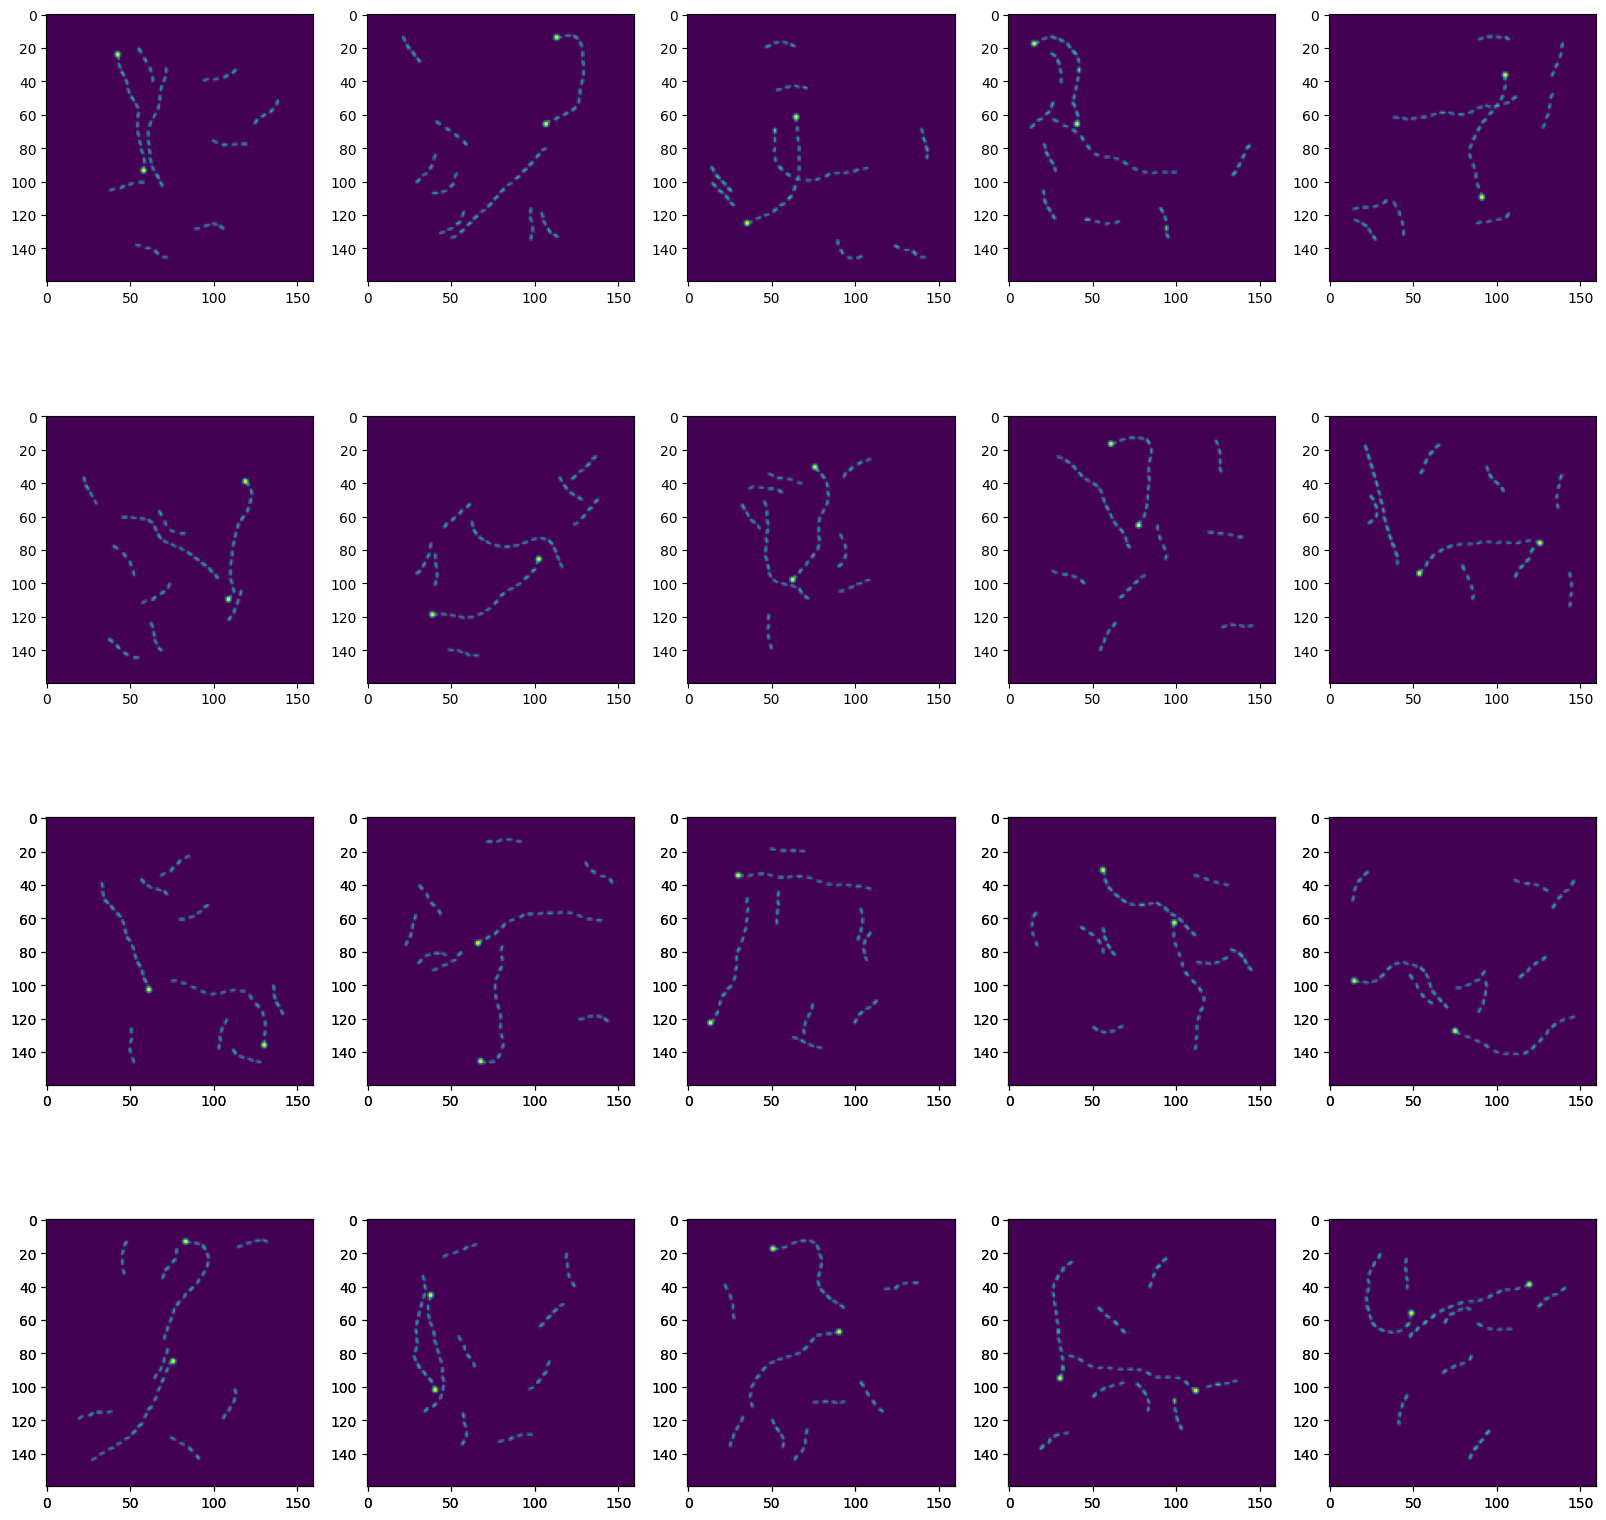

In [8]:
random_pos_examples = np.random.choice(99992//2, 20)
random_neg_examples = np.random.choice(np.arange(99992//2, 99992), 20)
fig = plt.figure(figsize=(20,20))
for idx, x in enumerate(all_images[random_pos_examples]):
    fig.add_subplot(4,5,idx+1)
    plt.imshow(x)
for idx, x in enumerate(all_images[random_neg_examples]):
    fig.add_subplot(4,5,idx+11)
    plt.imshow(x)

## Contour length 9

In [ ]:
cmd = 'train.py -cfg dalernn-t-12-gate-ln-relu -nl 3 --doEntropyThresholding 0 --returnValidOutput 0 --tau 0.01 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 0 -wd 0 --in-res 160 --expname temp1 --seed 13'
args = parser.parse_args(shlex.split(cmd))
args.cfg = load_cfg(args)
args.cfg['nlayers'] = args.nlayers
args.cfg['in_res'] = args.in_res

args.data = '/mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_9'

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

# Load val data
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(args.in_res),
            transforms.ToTensor(),
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)


In [ ]:
# Load existing checkpoint
print("=> loading checkpoint '{}'".format(args.resume))
# Map model to be loaded to specified single gpu.
loc = 'cuda:0'
checkpoint_file = 'ckpt_iclr/curv_contour_length_9/dalernn_gate_ln_relu/temp1_ksvdcd_seed_13/pathfinder_checkpoint_dalernn_gate_ln_relu_epoch_19.pth'
checkpoint = torch.load(checkpoint_file, map_location=loc)
# best_acc1 = checkpoint['val_acc1']
# create model
num_classes = 2
args.cfg = create_config(args.cfg)
model = BaseModel(args.cfg, args)
model_name = args.cfg.name  # + str(args.cfg.nlayers)
args.model_name = model_name
model.cuda()
model.load_state_dict(checkpoint['model'])
model.rnn.total_step_count = 50000

criterion = nn.CrossEntropyLoss().cuda(args.gpu)
optimizer = torch.optim.Adam(model.parameters(), args.lr,
                             # momentum=args.momentum,
                             # weight_decay=args.weight_decay
                             )
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
val_acc1, (outputs, all_halt_probs, ponder_costs, targets) = validate(val_loader, model, criterion, optimizer=None, epoch=None, args=args)

In [ ]:
plt.figure(figsize=(10,2))
means = all_halt_probs.mean(axis=0)
stddevs = all_halt_probs.std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep')

plt.figure(figsize=(10,2))
gt_true_idxs = torch.where(targets == 0)[0]
means = all_halt_probs[gt_true_idxs].mean(axis=0)
stddevs = all_halt_probs[gt_true_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, GT True')

plt.figure(figsize=(10,2))
gt_false_idxs = torch.where(targets == 1)[0]
means = all_halt_probs[gt_false_idxs].mean(axis=0)
stddevs = all_halt_probs[gt_false_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, GT False')

In [ ]:
incorrect_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==0))[0]
incorrect_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==1))[0]
correct_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0))[0]
correct_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1))[0]

incorrect_gt_false_probs = all_halt_probs[incorrect_gt_false_idxs]
incorrect_gt_true_probs = all_halt_probs[incorrect_gt_true_idxs]
correct_gt_false_probs = all_halt_probs[correct_gt_false_idxs]
correct_gt_true_probs = all_halt_probs[correct_gt_true_idxs]

In [ ]:
num_steps_all = (all_halt_probs != 0).sum(dim=1)
counts = Counter(num_steps_all.tolist())
print(counts)
num_steps, freq = zip(*counts.items())

In [ ]:
plt.figure(figsize=(3,3))
plt.bar(num_steps, freq)

In [ ]:
correct_gt_true_steps4_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0) * (num_steps_all == 4))[0]
correct_gt_true_steps5_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0) * (num_steps_all == 5))[0]
correct_gt_false_steps4_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1) * (num_steps_all == 4))[0]
correct_gt_false_steps5_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1) * (num_steps_all == 5))[0]

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(6,6))

num_steps_run = (incorrect_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0,0].bar(num_steps, freq)
axs[0,0].set_xlabel('Number of steps')
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_title('GT True, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (incorrect_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0, 1].bar(num_steps, freq)
axs[0, 1].set_xlabel('Number of steps')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('GT False, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 0].bar(num_steps, freq)
axs[1, 0].set_xlabel('Number of steps')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('GT True, Correct')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 1].bar(num_steps, freq)
axs[1, 1].set_xlabel('Number of steps')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('GT False, Correct')
print(Counter(num_steps_run.tolist()))


In [ ]:
all_images = []
for x in tqdm(val_loader):
    inputs, _ = x
    all_images.append(inputs)
all_images = torch.cat(all_images, dim=0)
all_images = all_images[:, 0, :, :]

In [ ]:
sampled_gt_true_steps4_idxs = np.random.choice(correct_gt_true_steps4_idxs, size=10, replace=False)
sampled_gt_true_steps5_idxs = np.random.choice(correct_gt_true_steps5_idxs, size=10, replace=False)
sampled_gt_false_steps4_idxs = np.random.choice(correct_gt_false_steps4_idxs, size=10, replace=False)
sampled_gt_false_steps5_idxs = np.random.choice(correct_gt_false_steps5_idxs, size=10, replace=False)

In [ ]:
fig = plt.figure(figsize=(20,20))
for idx, x in enumerate(all_images[sampled_gt_true_steps4_idxs]):
    fig.add_subplot(4,5,idx+1)
    plt.imshow(x)
for idx, x in enumerate(all_images[sampled_gt_true_steps5_idxs]):
    fig.add_subplot(4,5,idx+11)
    plt.imshow(x)

## Model 9 tested on Contour length 14 data; and vice versa

In [ ]:
cmd = 'train.py -cfg dalernn-t-12-gate-ln-relu -nl 3 --doEntropyThresholding 0 --returnValidOutput 0 --tau 0.01 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 0 -wd 0 --in-res 160 --expname temp1 --seed 13'
args = parser.parse_args(shlex.split(cmd))
args.cfg = load_cfg(args)
args.cfg['nlayers'] = args.nlayers
args.cfg['in_res'] = args.in_res

# Data for 9 lengths
# args.data = '/mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_9'
# Data for 14 lengths
args.data = '/home/vveeraba/src/pathfinder_full/curv_contour_length_14'

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

# Load val data
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(args.in_res),
            transforms.ToTensor(),
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

In [ ]:
# Load existing checkpoint
print("=> loading checkpoint '{}'".format(args.resume))
# Map model to be loaded to specified single gpu.
loc = 'cuda:0'

# Model for 9 lengths
checkpoint_file = 'ckpt_iclr/curv_contour_length_9/dalernn_gate_ln_relu/temp1_ksvdcd_seed_13/pathfinder_checkpoint_dalernn_gate_ln_relu_epoch_19.pth'
# Model for 14 lengths
# checkpoint_file = 'ckpt_iclr/curv_contour_length_14/dalernn_gate_ln_relu/act_seed_13/pathfinder_checkpoint_best_dalernn_gate_ln_relu.pth'


checkpoint = torch.load(checkpoint_file, map_location=loc)
# best_acc1 = checkpoint['val_acc1']
# create model
num_classes = 2
args.cfg = create_config(args.cfg)
model = BaseModel(args.cfg, args)
model_name = args.cfg.name  # + str(args.cfg.nlayers)
args.model_name = model_name
model.cuda()
model.load_state_dict(checkpoint['model'])
model.rnn.total_step_count = 10e7

criterion = nn.CrossEntropyLoss().cuda(args.gpu)
optimizer = torch.optim.Adam(model.parameters(), args.lr,
                             # momentum=args.momentum,
                             # weight_decay=args.weight_decay
                             )
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
val_acc1, (outputs, all_halt_probs, ponder_costs, targets) = validate(val_loader, model, criterion, optimizer=None, epoch=None, args=args)

In [ ]:
plt.figure(figsize=(10,2))
means = all_halt_probs.mean(axis=0)
stddevs = all_halt_probs.std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep')

plt.figure(figsize=(10,2))
gt_true_idxs = torch.where(targets == 0)[0]
means = all_halt_probs[gt_true_idxs].mean(axis=0)
stddevs = all_halt_probs[gt_true_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, GT True')

plt.figure(figsize=(10,2))
gt_false_idxs = torch.where(targets == 1)[0]
means = all_halt_probs[gt_false_idxs].mean(axis=0)
stddevs = all_halt_probs[gt_false_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, GT False')

In [ ]:
incorrect_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==0))[0]
incorrect_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==1))[0]
correct_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0))[0]
correct_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1))[0]

incorrect_gt_false_probs = all_halt_probs[incorrect_gt_false_idxs]
incorrect_gt_true_probs = all_halt_probs[incorrect_gt_true_idxs]
correct_gt_false_probs = all_halt_probs[correct_gt_false_idxs]
correct_gt_true_probs = all_halt_probs[correct_gt_true_idxs]

In [ ]:
num_steps_all = (all_halt_probs != 0).sum(dim=1)
counts = Counter(num_steps_all.tolist())
print(counts)
num_steps, freq = zip(*counts.items())

In [ ]:
plt.figure(figsize=(3,3))
plt.bar(num_steps, freq)

In [ ]:
correct_gt_true_steps4_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0) * (num_steps_all == 4))[0]
correct_gt_true_steps5_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0) * (num_steps_all == 5))[0]
correct_gt_false_steps4_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1) * (num_steps_all == 4))[0]
correct_gt_false_steps5_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1) * (num_steps_all == 5))[0]

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(6,6))

num_steps_run = (incorrect_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0,0].bar(num_steps, freq)
axs[0,0].set_xlabel('Number of steps')
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_title('GT True, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (incorrect_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0, 1].bar(num_steps, freq)
axs[0, 1].set_xlabel('Number of steps')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('GT False, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 0].bar(num_steps, freq)
axs[1, 0].set_xlabel('Number of steps')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('GT True, Correct')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 1].bar(num_steps, freq)
axs[1, 1].set_xlabel('Number of steps')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('GT False, Correct')
print(Counter(num_steps_run.tolist()))


In [ ]:
all_images = []
for x in tqdm(val_loader):
    inputs, _ = x
    all_images.append(inputs)
all_images = torch.cat(all_images, dim=0)
all_images = all_images[:, 0, :, :]

In [ ]:
sampled_gt_true_steps4_idxs = np.random.choice(correct_gt_true_steps4_idxs, size=10, replace=False)
sampled_gt_true_steps5_idxs = np.random.choice(correct_gt_true_steps5_idxs, size=10, replace=False)
sampled_gt_false_steps4_idxs = np.random.choice(correct_gt_false_steps4_idxs, size=10, replace=False)
sampled_gt_false_steps5_idxs = np.random.choice(correct_gt_false_steps5_idxs, size=10, replace=False)

In [ ]:
fig = plt.figure(figsize=(20,20))
for idx, x in enumerate(all_images[sampled_gt_true_steps4_idxs]):
    fig.add_subplot(4,5,idx+1)
    plt.imshow(x)
for idx, x in enumerate(all_images[sampled_gt_true_steps5_idxs]):
    fig.add_subplot(4,5,idx+11)
    plt.imshow(x)

## Combined Contour lengths 9 + 14 + 18

### First create a joint dataset

In [ ]:
data9 = '/mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_9'
data14 = '/home/vveeraba/src/pathfinder_full/curv_contour_length_14'
data18 = '/home/yutang/curv_contour_length_18_1M'
data_combined = '/mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_combined/'

# 24 folders in 9, 24 folders in 14, 20 folders in 18
# so combined will have 68 folders total


In [ ]:
ls /mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_combined/curv_contour_length_combined

In [ ]:
import re
regex = r"(\/imgs\/)(.*)(\/sample.*)"

In [ ]:
!head -10 val.txt

In [ ]:
with open('train.txt', 'r') as filein, open('new_train.txt', 'w') as fileout:
    for test_str in filein:
        test_str = test_str.strip()
        matches = list(re.finditer(regex, test_str, re.MULTILINE))
        assert len(matches) == 1
        folder_num = int(test_str[matches[0].start(2):matches[0].end(2)])
        test_str = test_str.replace(str(folder_num), str(folder_num + 0))
        test_str = test_str.replace('length_9', 'length_combined')
        fileout.write(test_str + '\n')

In [ ]:
!tail -5 new_train.txt

In [ ]:
!wc -l new_val.txt

In [ ]:
!cp /mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_9/train.txt ./train9.txt
!cp /mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_9/val.txt ./val9.txt
!cp /mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_9/test.txt ./test9.txt
!cp /home/vveeraba/src/pathfinder_full/curv_contour_length_14/train.txt ./train14.txt
!cp /home/vveeraba/src/pathfinder_full/curv_contour_length_14/val.txt ./val14.txt
!cp /home/vveeraba/src/pathfinder_full/curv_contour_length_14/test.txt ./test14.txt
!cp /home/yutang/curv_contour_length_18_1M/train.txt ./train18.txt
!cp /home/yutang/curv_contour_length_18_1M/val.txt ./val18.txt
!cp /home/yutang/curv_contour_length_18_1M/test.txt ./test18.txt

In [ ]:
for fold in ['train', 'val', 'test']:
    with open('{}18.txt'.format(fold), 'r') as filein, open('new_{}.txt'.format(fold), 'a') as fileout:
        for test_str in filein:
            test_str = test_str.strip()
            matches = list(re.finditer(regex, test_str, re.MULTILINE))
            assert len(matches) == 1
            folder_num = int(test_str[matches[0].start(2):matches[0].end(2)])
            test_str = test_str.replace('imgs/' + str(folder_num), 'imgs/' + str(folder_num + 48))
            test_str = test_str.replace('/home/AD/yutang/curv_contour_length_18_1M/curv_contour_length_18', '/mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_combined/curv_contour_length_combined')
#             test_str = test_str.replace('curv_contour_length_14', '/mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_combined/curv_contour_length_combined')
#             test_str = test_str.replace('curv_contour_length_9', 'curv_contour_length_combined')
            fileout.write(test_str + '\n')

In [41]:
data = []
with open('val.txt', 'r') as filein:
    for line in filein:
        data.append(line.strip())    

In [45]:
to_keep = data[:99992 * 2]
to_change = data[99992 * 2:]

In [46]:
len(to_change)

200000

In [49]:
to_change_pos = [x for x in to_change if 'neg' not in x]
to_change_neg = [x for x in to_change if 'neg' in x]

In [52]:
randomly_sampled_pos = np.random.choice(100000, size=99992//2, replace=False)
randomly_sampled_neg = np.random.choice(100000, size=99992//2, replace=False)

In [53]:
subsampled_pos = [to_change_pos[x] for x in randomly_sampled_pos]
subsampled_neg = [to_change_neg[x] for x in randomly_sampled_neg]

In [54]:
to_keep.extend(subsampled_pos)
to_keep.extend(subsampled_neg)

In [56]:
with open('balanced_val.txt', 'w') as fileout:
    for x in to_keep:
        fileout.write(x + '\n')    

### Evaluate model

In [4]:
cmd = 'train.py -cfg dalernn-t-12-gate-ln-relu -nl 3 --doEntropyThresholding 0 --returnValidOutput 0 --tau 0.01 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 0 -wd 0 --in-res 160 --expname temp1 --seed 13'
args = parser.parse_args(shlex.split(cmd))
args.cfg = load_cfg(args)
args.cfg['nlayers'] = args.nlayers
args.cfg['in_res'] = args.in_res

args.data = '/mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_combined'

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

# Load val data
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(args.in_res),
            transforms.ToTensor(),
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

In [5]:
# Load existing checkpoint
print("=> loading checkpoint '{}'".format(args.resume))
# Map model to be loaded to specified single gpu.
loc = 'cuda:0'
checkpoint_file = 'ckpt_iclr/curv_contour_length_combined/dalernn_gate_ln_relu/balanced_nwffum_seed_14/pathfinder_checkpoint_best_dalernn_gate_ln_relu.pth'
checkpoint = torch.load(checkpoint_file, map_location=loc)
best_acc1 = checkpoint['val_acc1']
# create model
num_classes = 2
args.cfg = create_config(args.cfg)
model = BaseModel(args.cfg, args)
model_name = args.cfg.name  # + str(args.cfg.nlayers)
args.model_name = model_name
model.cuda()
model.load_state_dict(checkpoint['model'])
model.rnn.total_step_count = 50000

criterion = nn.CrossEntropyLoss().cuda(args.gpu)
optimizer = torch.optim.Adam(model.parameters(), args.lr,
                             # momentum=args.momentum,
                             # weight_decay=args.weight_decay
                             )
optimizer.load_state_dict(checkpoint['optimizer'])

=> loading checkpoint ''
12 steps of recurrence
Using interneuron


In [6]:
val_acc1, (outputs, all_halt_probs, ponder_costs, state_magnitudes, targets) = validate(val_loader, model, criterion, optimizer=None, epoch=None, args=args)

/home/AD/srravishankar/anaconda3/envs/pytorch_111/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test: [   0/1172]	Time  3.328 ( 3.328)	Loss 7.7895e-03 (7.7895e-03)	Acc@1 100.00 (100.00)
Test: [  10/1172]	Time  0.186 ( 0.493)	Loss 1.3052e-02 (2.9128e-02)	Acc@1  99.22 ( 99.01)
Test: [  20/1172]	Time  0.190 ( 0.419)	Loss 4.1857e-02 (2.4792e-02)	Acc@1  98.83 ( 99.11)
Test: [  30/1172]	Time  0.185 ( 0.392)	Loss 4.5794e-03 (2.2121e-02)	Acc@1 100.00 ( 99.21)
Test: [  40/1172]	Time  0.187 ( 0.410)	Loss 1.9114e-02 (2.3407e-02)	Acc@1  99.61 ( 99.18)
Test: [  50/1172]	Time  0.187 ( 0.383)	Loss 3.7808e-02 (2.2173e-02)	Acc@1  98.83 ( 99.23)
Test: [  60/1172]	Time  0.187 ( 0.352)	Loss 1.0787e-02 (2.1115e-02)	Acc@1  99.61 ( 99.26)
Test: [  70/1172]	Time  0.207 ( 0.340)	Loss 1.9984e-02 (2.1902e-02)	Acc@1  99.22 ( 99.22)
Test: [  80/1172]	Time  0.187 ( 0.324)	Loss 1.9667e-02 (2.1543e-02)	Acc@1  99.22 ( 99.22)
Test: [  90/1172]	Time  0.633 ( 0.331)	Loss 2.4862e-03 (2.1476e-02)	Acc@1 100.00 ( 99.23)
Test: [ 100/1172]	Time  0.187 ( 0.333)	Loss 1.2675e-02 (2.1074e-02)	Acc@1  99.22 ( 99.25)
Test: [ 11

Test: [ 920/1172]	Time  0.188 ( 0.369)	Loss 4.0031e-02 (4.9291e-02)	Acc@1  98.44 ( 98.06)
Test: [ 930/1172]	Time  1.386 ( 0.369)	Loss 5.0767e-02 (4.9297e-02)	Acc@1  97.27 ( 98.06)
Test: [ 940/1172]	Time  0.188 ( 0.367)	Loss 5.3099e-02 (4.9513e-02)	Acc@1  98.05 ( 98.05)
Test: [ 950/1172]	Time  0.188 ( 0.367)	Loss 2.0299e-02 (4.9568e-02)	Acc@1  99.22 ( 98.05)
Test: [ 960/1172]	Time  0.191 ( 0.367)	Loss 4.6934e-02 (4.9571e-02)	Acc@1  98.44 ( 98.06)
Test: [ 970/1172]	Time  0.225 ( 0.367)	Loss 2.5437e-02 (4.9647e-02)	Acc@1  99.22 ( 98.06)
Test: [ 980/1172]	Time  0.188 ( 0.368)	Loss 1.4393e-01 (5.0071e-02)	Acc@1  96.09 ( 98.04)
Test: [ 990/1172]	Time  0.188 ( 0.366)	Loss 1.7646e-01 (5.0952e-02)	Acc@1  94.53 ( 98.01)
Test: [1000/1172]	Time  0.186 ( 0.364)	Loss 1.0897e-01 (5.1850e-02)	Acc@1  94.92 ( 97.98)
Test: [1010/1172]	Time  0.188 ( 0.363)	Loss 1.5454e-01 (5.2668e-02)	Acc@1  95.31 ( 97.96)
Test: [1020/1172]	Time  0.192 ( 0.361)	Loss 1.1482e-01 (5.3194e-02)	Acc@1  94.92 ( 97.93)
Test: [103

In [7]:
incorrect_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==0))[0]
incorrect_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==1))[0]
correct_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0))[0]
correct_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1))[0]

incorrect_gt_false_probs = all_halt_probs[incorrect_gt_false_idxs]
incorrect_gt_true_probs = all_halt_probs[incorrect_gt_true_idxs]
correct_gt_false_probs = all_halt_probs[correct_gt_false_idxs]
correct_gt_true_probs = all_halt_probs[correct_gt_true_idxs]

Text(0.5, 1.0, '(Approx) Contribution of output by each timestep, GT False')

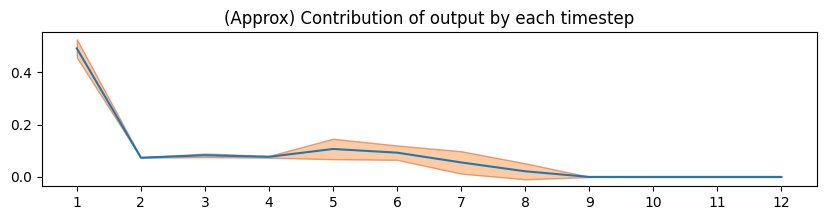

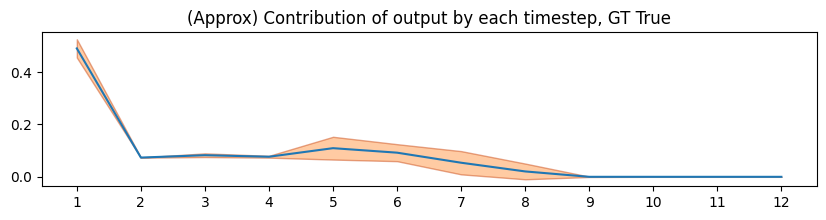

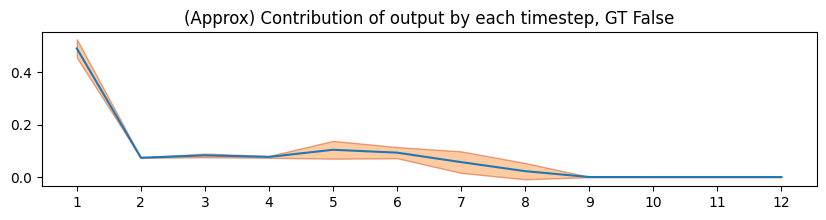

In [8]:
plt.figure(figsize=(10,2))
means = all_halt_probs.mean(axis=0)
stddevs = all_halt_probs.std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep')

plt.figure(figsize=(10,2))
gt_true_idxs = torch.where(targets == 0)[0]
means = all_halt_probs[gt_true_idxs].mean(axis=0)
stddevs = all_halt_probs[gt_true_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, GT True')

plt.figure(figsize=(10,2))
gt_false_idxs = torch.where(targets == 1)[0]
means = all_halt_probs[gt_false_idxs].mean(axis=0)
stddevs = all_halt_probs[gt_false_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, GT False')

Counter({8: 2533, 7: 571, 6: 232, 9: 39, 5: 1})
Counter({8: 2516, 7: 827, 6: 464, 9: 21, 5: 7})
Counter({8: 50009, 6: 47295, 7: 45467, 5: 3613, 9: 228})
Counter({8: 54201, 7: 50418, 6: 41152, 9: 263, 5: 119})


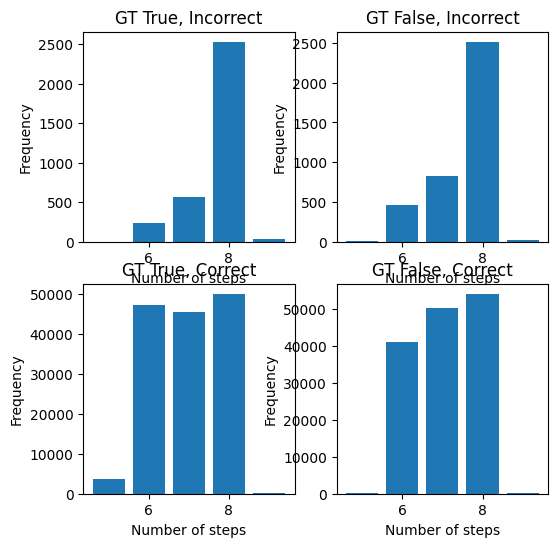

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(6,6))

num_steps_run = (incorrect_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0,0].bar(num_steps, freq)
axs[0,0].set_xlabel('Number of steps')
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_title('GT True, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (incorrect_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0, 1].bar(num_steps, freq)
axs[0, 1].set_xlabel('Number of steps')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('GT False, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 0].bar(num_steps, freq)
axs[1, 0].set_xlabel('Number of steps')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('GT True, Correct')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 1].bar(num_steps, freq)
axs[1, 1].set_xlabel('Number of steps')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('GT False, Correct')
print(Counter(num_steps_run.tolist()))


In [11]:
pos9 = torch.arange(0, 99992//2)
pos14 = torch.arange(99992//2, 99992)
pos18 = torch.arange(99992, 99992 + 99992 // 2)

neg9 = pos9 + (99992 * 3) // 2
neg14 = pos14 + (99992 * 3) // 2
neg18 = pos18 + (99992 * 3) // 2

contour_length9_idxs = torch.cat([pos9, neg9])
contour_length14_idxs = torch.cat([pos14, neg14])
contour_length18_idxs = torch.cat([pos18, neg18])

Counter({6: 82955, 7: 13276, 5: 3740, 8: 21})
Counter({7: 83375, 8: 10428, 6: 6188, 9: 1})
Counter({8: 98810, 7: 632, 9: 550})


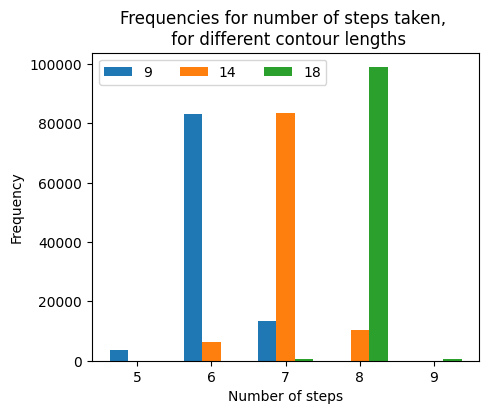

In [12]:
alpha_val = 1
fig, axs = plt.subplots(1, 1, figsize=(5,4))
width = 0.25

halt_probs_of_interest = all_halt_probs[contour_length9_idxs]
num_steps_run = (halt_probs_of_interest != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs.bar((np.array(num_steps) - width), freq, width=width, alpha=alpha_val)
print(Counter(num_steps_run.tolist()))

halt_probs_of_interest = all_halt_probs[contour_length14_idxs]
num_steps_run = (halt_probs_of_interest != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs.bar((np.array(num_steps)).tolist(), freq, width=width, alpha=alpha_val)
print(Counter(num_steps_run.tolist()))

halt_probs_of_interest = all_halt_probs[contour_length18_idxs]
num_steps_run = (halt_probs_of_interest != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs.bar((np.array(num_steps) + width).tolist(), freq, width=width, alpha=alpha_val)
print(Counter(num_steps_run.tolist()))

axs.set_xlabel('Number of steps')
axs.set_ylabel('Frequency')
axs.set_title('Frequencies for number of steps taken, \n for different contour lengths')
axs.set_xticks([5,6,7,8,9])
axs.legend(['9', '14', '18'],loc='upper left', ncols=3)

Text(0.5, 1.0, '(Approx) Contribution of output by each timestep, Contour Length 18')

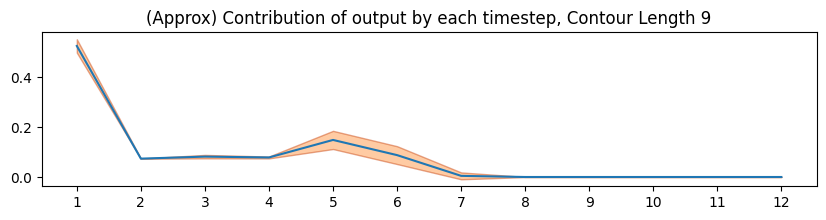

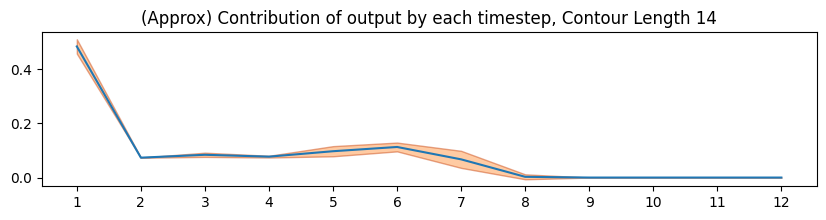

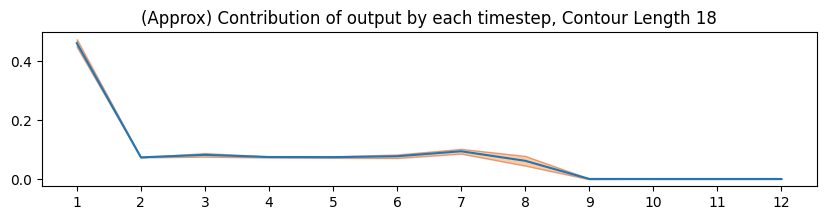

In [13]:
plt.figure(figsize=(10,2))
means = all_halt_probs[contour_length9_idxs].mean(axis=0)
stddevs = all_halt_probs[contour_length9_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 9')

plt.figure(figsize=(10,2))
means = all_halt_probs[contour_length14_idxs].mean(axis=0)
stddevs = all_halt_probs[contour_length14_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 14')

plt.figure(figsize=(10,2))
means = all_halt_probs[contour_length18_idxs].mean(axis=0)
stddevs = all_halt_probs[contour_length18_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 18')

Text(0.5, 1.0, '(Approx) Contribution of output by each timestep, Contour Length 18')

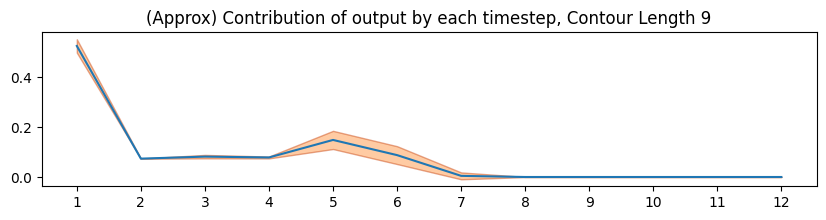

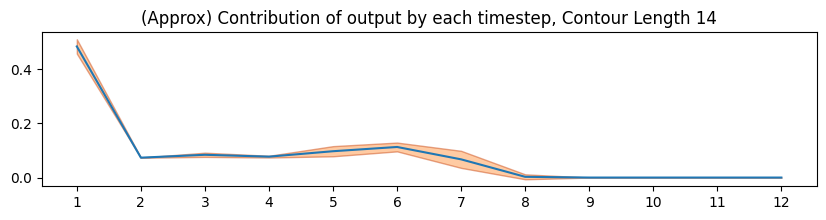

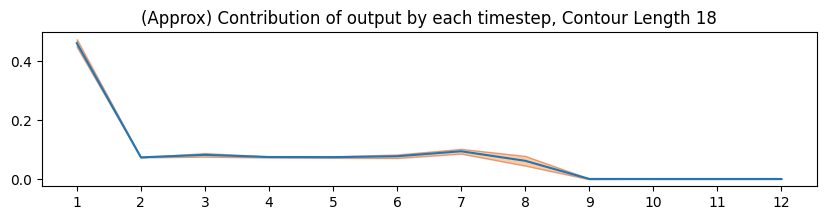

In [14]:
plt.figure(figsize=(10,2))
means = all_halt_probs[contour_length9_idxs].mean(axis=0)
stddevs = all_halt_probs[contour_length9_idxs].std(axis=0)
plt.plot(range(1,13), means)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 9')

plt.figure(figsize=(10,2))
means = all_halt_probs[contour_length14_idxs].mean(axis=0)
stddevs = all_halt_probs[contour_length14_idxs].std(axis=0)
plt.plot(range(1,13), means)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 14')

plt.figure(figsize=(10,2))
means = all_halt_probs[contour_length18_idxs].mean(axis=0)
stddevs = all_halt_probs[contour_length18_idxs].std(axis=0)
plt.plot(range(1,13), means)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 18')

Text(0.5, 1.0, '(Approx) Contribution of output by each timestep, Contour Length 18')

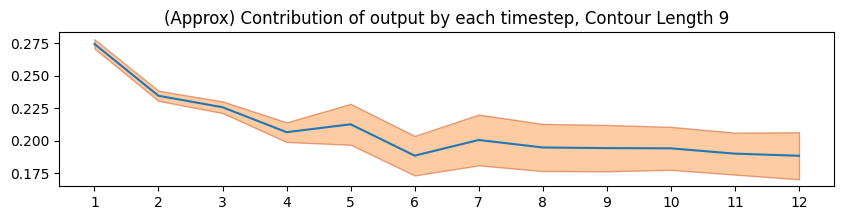

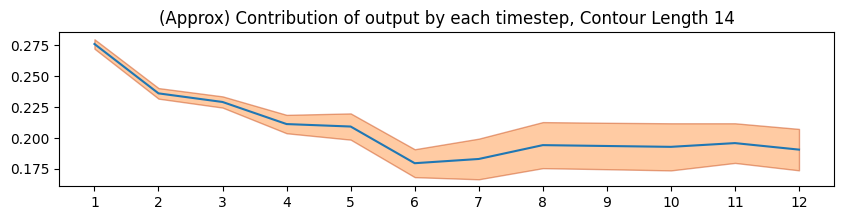

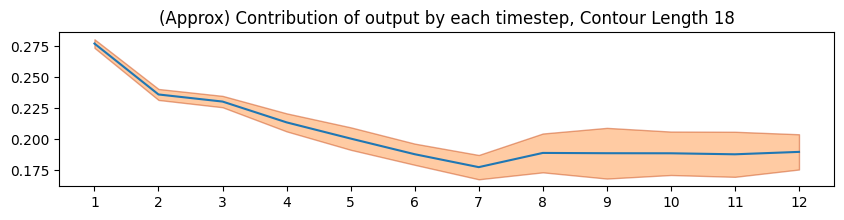

In [15]:
plt.figure(figsize=(10,2))
means = state_magnitudes[contour_length9_idxs].mean(axis=0)
stddevs = state_magnitudes[contour_length9_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 9')

plt.figure(figsize=(10,2))
means = state_magnitudes[contour_length14_idxs].mean(axis=0)
stddevs = state_magnitudes[contour_length14_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 14')

plt.figure(figsize=(10,2))
means = state_magnitudes[contour_length18_idxs].mean(axis=0)
stddevs = state_magnitudes[contour_length18_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 18')

Text(0.5, 1.0, '(Approx) Contribution of output by each timestep, Contour Length 18')

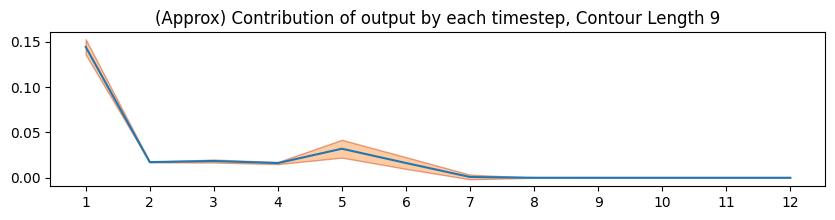

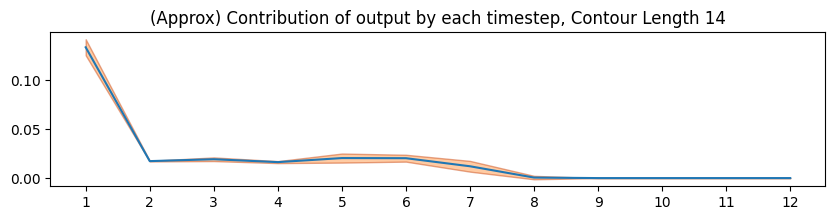

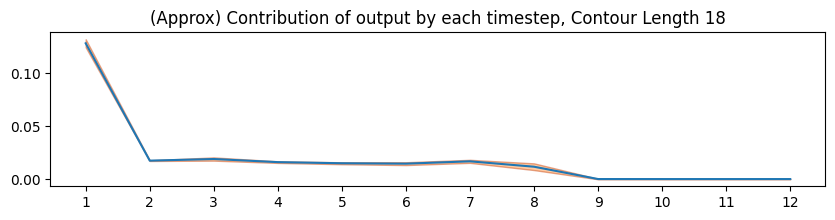

In [16]:
plt.figure(figsize=(10,2))

# Halt probs weighted by mean abs value of state
normalized_contributions = all_halt_probs * state_magnitudes

means = normalized_contributions[contour_length9_idxs].mean(axis=0)
stddevs = normalized_contributions[contour_length9_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 9')

plt.figure(figsize=(10,2))
means = normalized_contributions[contour_length14_idxs].mean(axis=0)
stddevs = normalized_contributions[contour_length14_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 14')

plt.figure(figsize=(10,2))
means = normalized_contributions[contour_length18_idxs].mean(axis=0)
stddevs = normalized_contributions[contour_length18_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 18')

In [37]:
all_images = []
for x in tqdm(val_loader):
    inputs, _ = x
    all_images.append(inputs)
all_images = torch.cat(all_images, dim=0)
all_images = all_images[:, 0, :, :]

100%|███████████████████████████████████████████████████████████████████████████████| 1172/1172 [04:05<00:00,  4.78it/s]


### Check if difficulty corresponds to number of steps

In [ ]:
# Within all 14 length contours, get 10 examples each of steps 6, 7 and 8
num_steps_run = (all_halt_probs != 0).sum(dim=1).numpy()
temp2 = set(contour_length14_idxs.tolist())

temp = np.where(num_steps_run==6)[0]
length14_step6_idxs = np.array([x for x in temp if x in temp2])
temp = np.where(num_steps_run==7)[0]
length14_step7_idxs = np.array([x for x in temp if x in temp2])
temp = np.where(num_steps_run==8)[0]
length14_step8_idxs = np.array([x for x in temp if x in temp2])

In [75]:
sampled_step6_idxs = np.random.choice(length14_step6_idxs, size=5, replace=False)
sampled_step7_idxs = np.random.choice(length14_step7_idxs, size=5, replace=False)
sampled_step8_idxs = np.random.choice(length14_step8_idxs, size=5, replace=False)

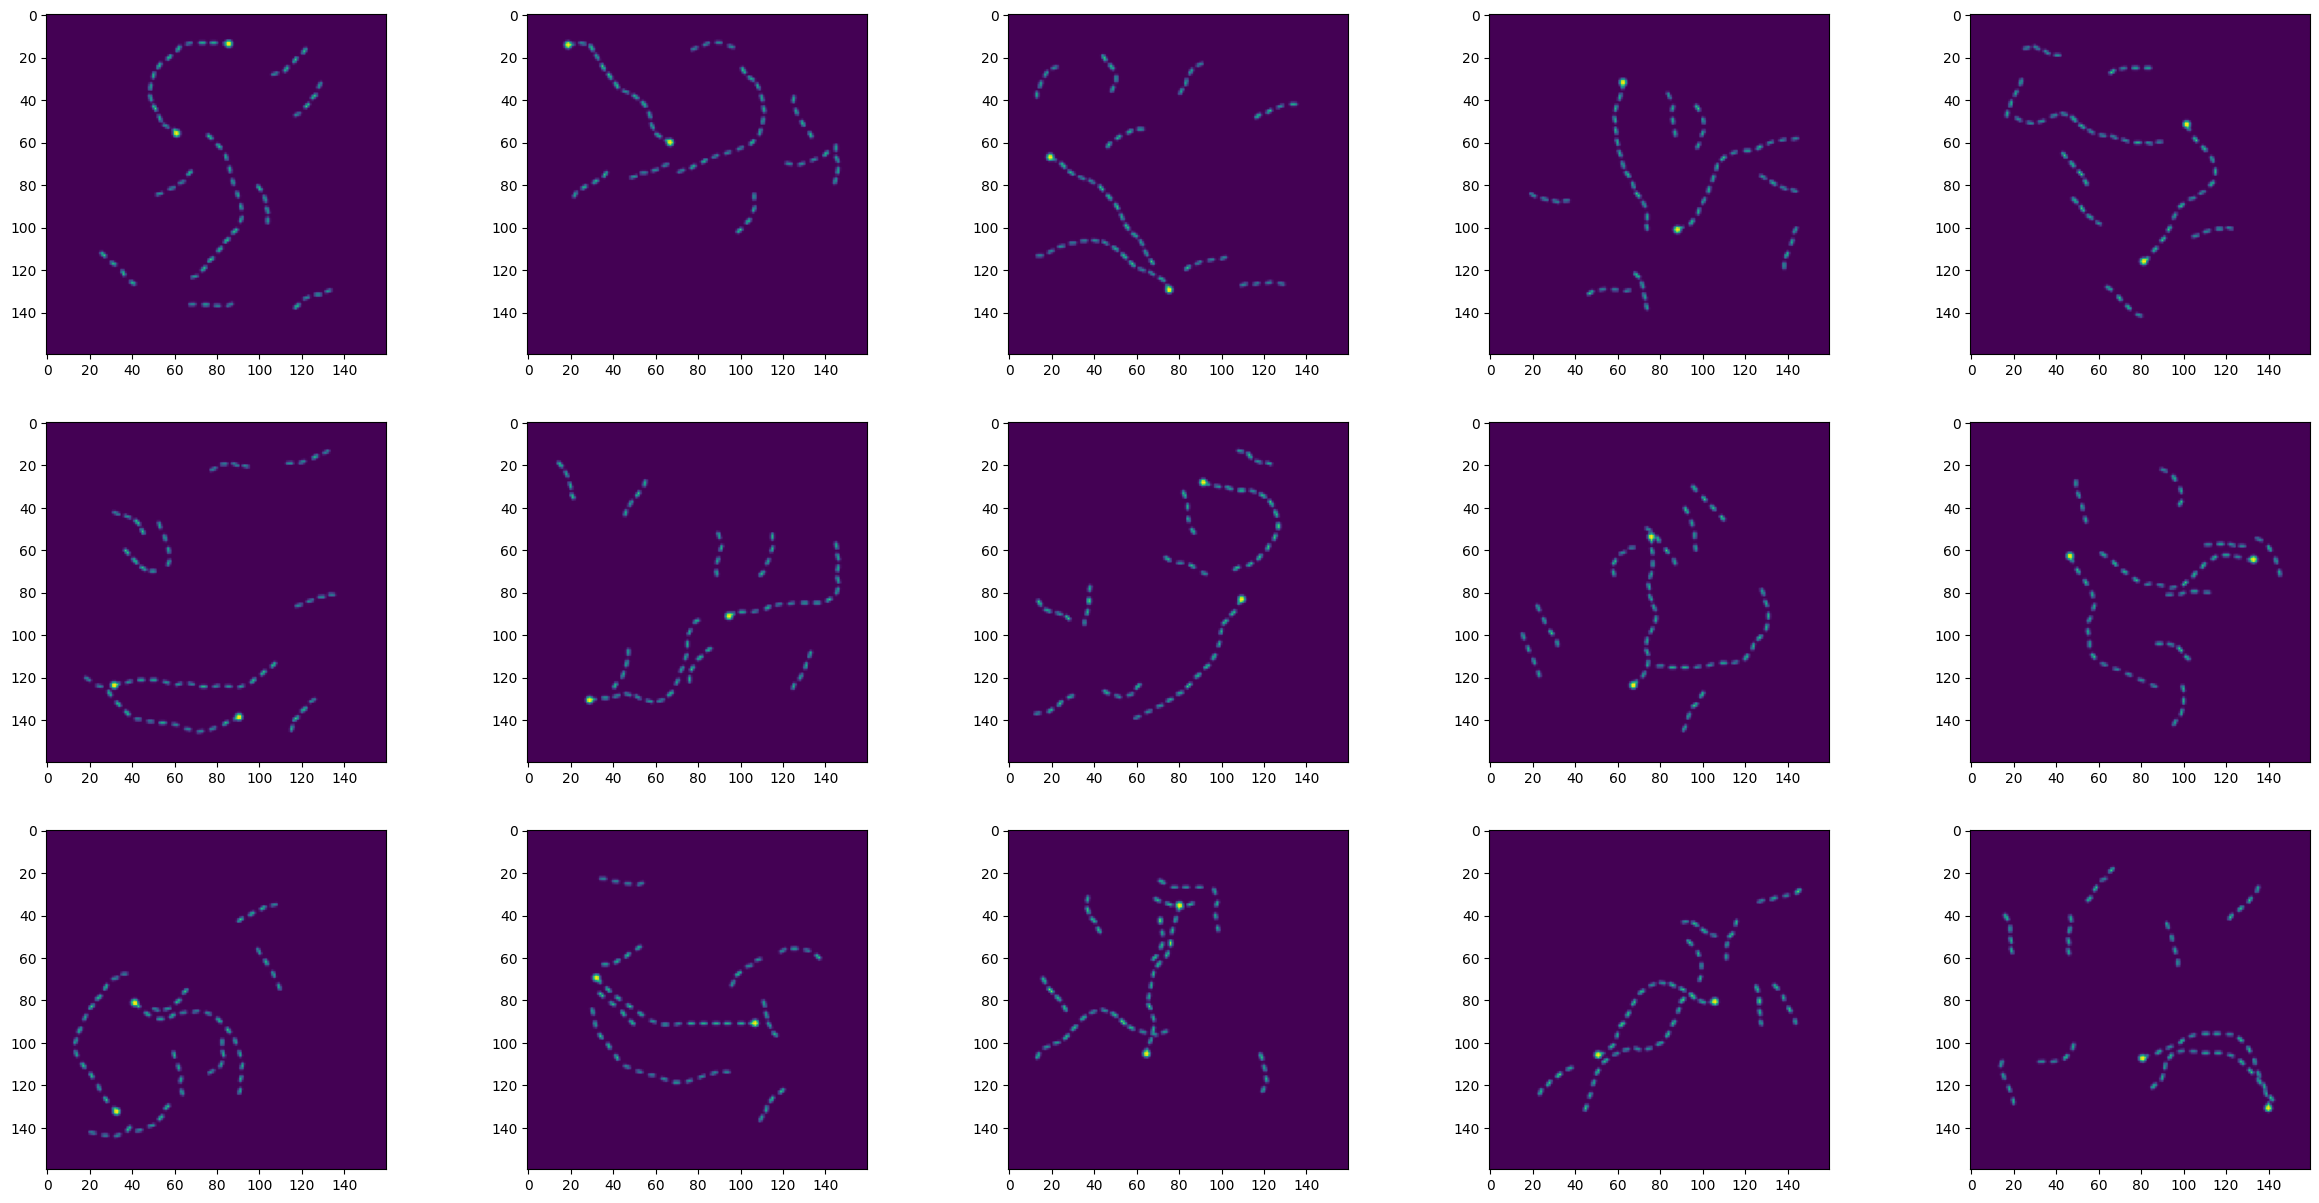

In [76]:
fig = plt.figure(figsize=(30,15))
for idx, x in enumerate(all_images[sampled_step6_idxs]):
    fig.add_subplot(3,5,idx+1)
    plt.imshow(x)
for idx, x in enumerate(all_images[sampled_step7_idxs]):
    fig.add_subplot(3,5,idx+6)
    plt.imshow(x)
for idx, x in enumerate(all_images[sampled_step8_idxs]):
    fig.add_subplot(3,5,idx+11)
    plt.imshow(x)

### Inspect state activations

In [17]:
model.readout, model.final_conv

(Linear(in_features=2, out_features=2, bias=True),
 Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1)))

In [97]:
# We apply the final layer (32 x 1) to each point in the 32 x 40 x 40 state vector at each timepoint. Gives us a 40 x 40 image
state_activations = []
model.eval()
for i, (images, target) in tqdm(enumerate(val_loader)):
        images = images.cuda(args.gpu, non_blocking=True)
        x, halt_probs, ponder_cost = model.backbone(images)
        x = torch.stack(x)   # x is num_timesteps x bs x hidden_dim   
        num_timesteps, bs, nc, d1, d2 = x.shape
        x = x.reshape(num_timesteps * bs, nc, d1, d2)
        x = model.final_conv(x) # x's shape : num_timesteps * bs, 2, 40, 40 
        # x = self.final_pool(x) We don't do this since we want to inspect spatial patterns of activation
        x = x.transpose(1,3)
        x = model.readout(x).transpose(1,2)
        x = x.reshape(num_timesteps, bs, 40, 40, 2)[:, :, :, :, 0]
        state_activations.append(x.transpose(0, 1).detach().cpu())
state_activations = torch.cat(state_activations, dim=0)

1172it [03:41,  5.30it/s]


In [124]:
examples = np.random.choice(state_activations.shape[0], 3)

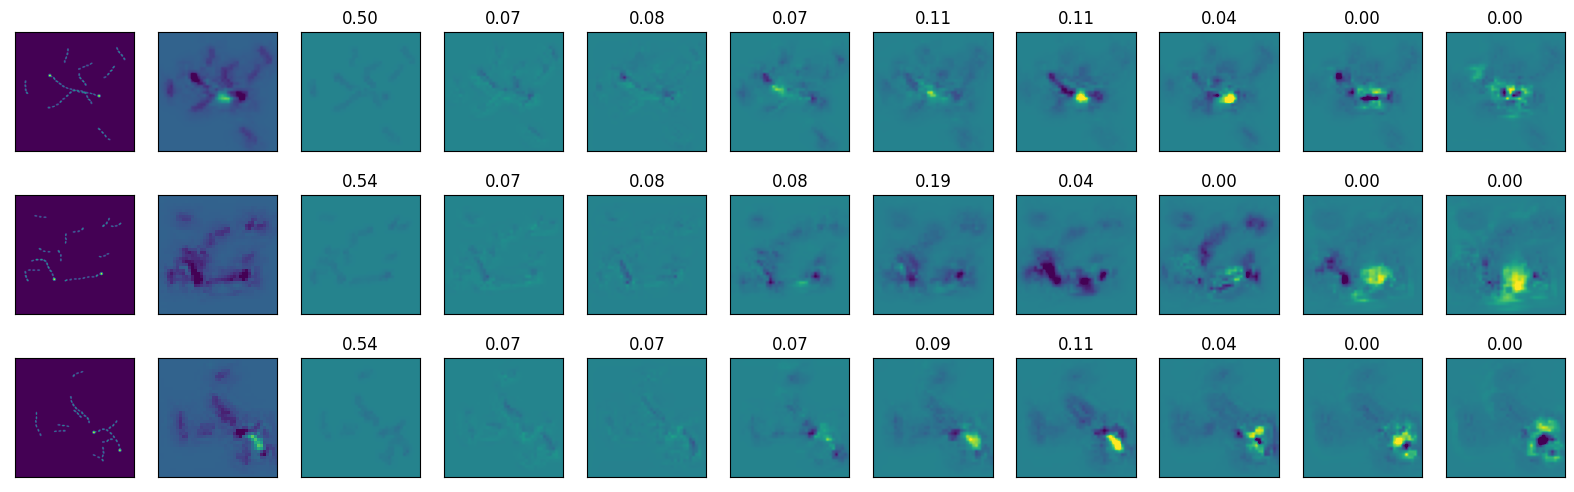

In [125]:
fig = plt.figure(figsize=(20,2 * len(examples)))
num_timesteps_shown = 9
ncols = num_timesteps_shown + 2
for idx, example_idx in enumerate(examples):
    fig.add_subplot(len(examples), ncols, 1 + (ncols * idx))
    plt.imshow(all_images[example_idx])    
    plt.xticks([])
    plt.yticks([])
    fig.add_subplot(len(examples), ncols, 2 + (ncols * idx))
    avg_state_activations = (all_halt_probs[example_idx].tile((40, 40, 1)).transpose(0, 2) * state_activations[example_idx]).mean(axis=0)
    plt.imshow(avg_state_activations, cmap='viridis', vmin=-0.25, vmax=0.25)    
    plt.xticks([])
    plt.yticks([])
    for timestep in range(num_timesteps_shown):
        fig.add_subplot(len(examples), ncols, timestep + 3 + (ncols * idx))
        plt.imshow(state_activations[example_idx][timestep, :, :], cmap='viridis', vmin=-10, vmax=10)
        plt.xticks([])
        plt.yticks([])
        plt.title('{:.2f}'.format(all_halt_probs[example_idx, timestep].item()))